ROLLING CROSS VALIDATION

In [153]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [154]:
import xarray as xr

nh3_nc = xr.load_dataset('../datasets/CAMS-GLOB-ANT_Glb_0.1x0.1_anthro_nh3_v4.2_monthly_lombardia.nc') # Copernicus (0.1°x0.1°)

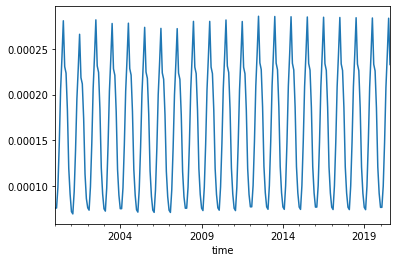

In [155]:
from utils import utils
import matplotlib.pyplot as plt

nh3 = utils.xarray2pandas(nh3_nc.agl, 6, 17).to_period('M')
nh3.plot()
plt.show()

In [156]:
def multiple_forecasts(model, ts, times, refit=False):
    
    predictions = []
    errors = []

    for i in range(len(ts)):
        prediction = model.forecast()
        model = model.append([prediction.values[0]], refit=refit)
        predictions.append(prediction.values[0])
        errors.append(ts.values[i] - prediction.values[0])
    
    return predictions, errors

In [157]:
def autocorr(ts):
    errors = pd.Series(ts)
    n = len(ts)
    data = np.asarray(ts)
    mean = np.mean(data)
    c0 = np.sum((data - mean) ** 2) / float(n)

    def r(h):
        return ((data[:n - h] - mean) * (data[h:] - mean)).sum() / float(n) / c0

    lags = np.arange(n) + 1
    return list(map(r, lags))

In [158]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
import pandas as pd

# TODO Passare come ts la serie senza il 2020
def rolling_cross_validation(ts, order, seasonal_order, initial_train_months=36, verbose=False):

    aics = []
    bics = []
    rmses = []
    sses = []
    mses = []
    year_autocorrs_in_sample = []
    year_autocorrs_out_of_sample = []
    is_correct = True

    train_months = initial_train_months # Mesi di training allo step iniziale
    n = len(ts)

    while train_months < (n-12):
        train_data = ts[0:train_months]
        validation_data = ts[train_months:train_months+12] # Validazione fissa ai 12 mesi successivi

        model = ARIMA(endog=train_data, order=order, seasonal_order=seasonal_order).fit()

        aics.append(model.aic)
        bics.append(model.bic)

        # Out of sample
        predictions, errors = multiple_forecasts(model=model, ts=validation_data, times=len(validation_data), refit=False)
        rmse = np.sqrt(np.mean(((predictions - validation_data.values) ** 2)))
        rmses.append(rmse)

        sses.append(model.sse)
        mses.append(model.mse)

        # Autocorrelation at lag=12
        year_autocorrs_in_sample.append(autocorr(errors))
        year_autocorrs_out_of_sample.append(autocorr(model.resid)[12])

        # Check
        is_heteroskedastic = model.test_heteroskedasticity(method=None)[0,1] > 0.05
        is_normal = model.test_normality('jarquebera')[0, 1] > 0.05
        is_correct = is_correct and (is_heteroskedastic and is_normal)

        correct = {'correct': is_correct, 'normality': is_normal, 'heteroskedasticity': is_heteroskedastic}

        train_months += 12 # Incrementare i mesi di training
    
    return np.mean(rmses), np.mean(aics), np.mean(bics), np.mean(sses),  np.mean(mses), np.mean(np.abs(acf(model.resid))), np.mean(np.abs(year_autocorrs_out_of_sample)), correct

In [159]:
# SARIMAX(p,d,q,P,D,Q,s)

import numpy as np

def model_selection(ts, initial_train_months=36, verbose=False):
    p_list = [1, 2, 3]
    q_list = [0, 1, 2]
    P_list = [0, 1, 2]
    Q_list = [0, 1]
    s = 12

    results = {}
    idx = 0

    for p in p_list:
       for q in q_list:
            for P in P_list:
                for Q in Q_list:
                    
                    model_name = 'SARIMA(p={}, d=0, q={}, P={}, D=0, Q={}, s={})'.format(p, q, P, Q, s)
                    model_idx = idx

                    if verbose: print('{}: {}'.format(model_idx, model_name))
                    
                    rmse, aic, bic, sse, mse, meaacf, yac_out_of_sample, correct = rolling_cross_validation(ts=ts, order=(p,0,q), seasonal_order=(P,0,Q,s), initial_train_months=initial_train_months)

                    results[model_name] = {
                        'order' : (p,0,q),
                        'seasonal_order' : (P,0,Q,s),
                        'aic' : aic,
                        'bic' : bic,
                        'sse' : sse,
                        'rmse' : rmse,
                        'mse' : mse,
                        'index' : model_idx,
                        'mean_abs_acf': meaacf,
                        'yac_out_of_sample': yac_out_of_sample,
                        'correct': correct              
                        }

                    idx += 1
    return results

In [56]:
results = model_selection(nh3, initial_train_months=36, verbose=True)

0: SARIMA(p=1, d=0, q=0, P=0, D=0, Q=0, s=12
1: SARIMA(p=1, d=0, q=0, P=0, D=0, Q=1, s=12
2: SARIMA(p=1, d=0, q=0, P=1, D=0, Q=0, s=12
3: SARIMA(p=1, d=0, q=0, P=1, D=0, Q=1, s=12
4: SARIMA(p=1, d=0, q=0, P=2, D=0, Q=0, s=12
5: SARIMA(p=1, d=0, q=0, P=2, D=0, Q=1, s=12
6: SARIMA(p=1, d=0, q=1, P=0, D=0, Q=0, s=12
7: SARIMA(p=1, d=0, q=1, P=0, D=0, Q=1, s=12
8: SARIMA(p=1, d=0, q=1, P=1, D=0, Q=0, s=12
9: SARIMA(p=1, d=0, q=1, P=1, D=0, Q=1, s=12
10: SARIMA(p=1, d=0, q=1, P=2, D=0, Q=0, s=12
11: SARIMA(p=1, d=0, q=1, P=2, D=0, Q=1, s=12
12: SARIMA(p=1, d=0, q=2, P=0, D=0, Q=0, s=12
13: SARIMA(p=1, d=0, q=2, P=0, D=0, Q=1, s=12
14: SARIMA(p=1, d=0, q=2, P=1, D=0, Q=0, s=12
15: SARIMA(p=1, d=0, q=2, P=1, D=0, Q=1, s=12
16: SARIMA(p=1, d=0, q=2, P=2, D=0, Q=0, s=12
17: SARIMA(p=1, d=0, q=2, P=2, D=0, Q=1, s=12
18: SARIMA(p=2, d=0, q=0, P=0, D=0, Q=0, s=12
19: SARIMA(p=2, d=0, q=0, P=0, D=0, Q=1, s=12
20: SARIMA(p=2, d=0, q=0, P=1, D=0, Q=0, s=12
21: SARIMA(p=2, d=0, q=0, P=1, D=0, Q=1, s=1

In [108]:
filtered_results = {k: v for k, v in results.items() if v['correct'] is True}

In [109]:
aics = [v['aic'] for k, v in results.items()]
bics = [v['bic'] for k, v in results.items()]
rmses = [v['rmse'] for k, v in results.items()]
sses = [v['sse'] for k, v in results.items()]
mses = [v['mse'] for k, v in results.items()]
maacf = [v['mean_abs_acf'] for k, v in results.items()]
yac_out_of_sample = [v['yac_out_of_sample'] for k, v in results.items()]

In [83]:
def tick(order, seasonal_order):
    p, d, q = order
    P, D, Q, s = seasonal_order
    return str((p,q,P,Q))

ticks = [tick(v['order'], v['seasonal_order']) for k, v in sorted(results.items(), key=lambda item: item[1]['index'])]

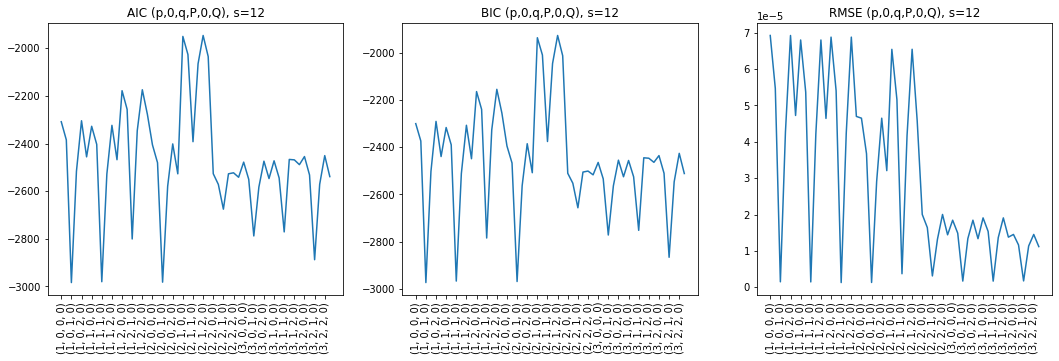

In [84]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,5))
indices = np.arange(0, len(results), 2)

axs[0].plot(aics)
axs[0].set_title('AIC (p,0,q,P,0,Q), s=12')
axs[0].set_xticks(indices)
axs[0].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[1].plot(bics)
axs[1].set_title('BIC (p,0,q,P,0,Q), s=12')
axs[1].set_xticks(indices)
axs[1].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[2].plot(rmses)
axs[2].set_title('RMSE (p,0,q,P,0,Q), s=12')
axs[2].set_xticks(indices)
axs[2].set_xticklabels(np.array(ticks)[indices], rotation=90)

plt.show()

In [85]:
print('min AIC: {}, min BIC {}, min RMSE {}'.format(np.argmin(aics), np.argmin(bics), np.argmin(rmses)))

min AIC: 2, min BIC 2, min RMSE 14


In [86]:
min_aic_model = [v for k,v in results.items() if v['aic'] == np.min(aics)][0]
min_aic_model

{'order': (1, 0, 0),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -2983.797724258262,
 'bic': -2972.764747775195,
 'sse': 2.2380195455967677e-08,
 'rmse': 1.538536592740279e-06,
 'mse': 2.2378296232621224e-10,
 'index': 2,
 'mean_abs_acf': 0.08451780999636535,
 'yac_in_sample': 0.19536169939050346,
 'yac_out_of_sample': 0.023495712181438467,
 'correct': {'correct': False,
  'normality': False,
  'heteroskedasticity': False}}

In [87]:
min_bic_model = [v for k,v in results.items() if v['bic'] == np.min(bics)][0]
min_bic_model

{'order': (1, 0, 0),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -2983.797724258262,
 'bic': -2972.764747775195,
 'sse': 2.2380195455967677e-08,
 'rmse': 1.538536592740279e-06,
 'mse': 2.2378296232621224e-10,
 'index': 2,
 'mean_abs_acf': 0.08451780999636535,
 'yac_in_sample': 0.19536169939050346,
 'yac_out_of_sample': 0.023495712181438467,
 'correct': {'correct': False,
  'normality': False,
  'heteroskedasticity': False}}

In [88]:
min_rmse_model = [v for k,v in results.items() if v['rmse'] == np.min(rmses)][0]
min_rmse_model

{'order': (1, 0, 2),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -2800.733943467476,
 'bic': -2784.1844787428745,
 'sse': 4.702702520889274e-08,
 'rmse': 1.3322506117604471e-06,
 'mse': 4.712862224845621e-10,
 'index': 14,
 'mean_abs_acf': 0.12413499573201481,
 'yac_in_sample': 0.19433874976465865,
 'yac_out_of_sample': 0.07009262884946062,
 'correct': {'correct': False,
  'normality': False,
  'heteroskedasticity': False}}

In [89]:
min_sse_model = [v for k,v in results.items() if v['sse'] == np.min(sses)][0]
min_sse_model

{'order': (3, 0, 1),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -2771.0362549402307,
 'bic': -2751.728546094863,
 'sse': 1.1306008769244172e-08,
 'rmse': 1.7308415841391979e-06,
 'mse': 1.1244930797882248e-10,
 'index': 44,
 'mean_abs_acf': 0.06819294697600724,
 'yac_in_sample': 0.22499982473676436,
 'yac_out_of_sample': 0.014339086709620181,
 'correct': {'correct': False,
  'normality': False,
  'heteroskedasticity': False}}

In [90]:
min_mse_model = [v for k,v in results.items() if v['mse'] == np.min(mses)][0]
min_mse_model

{'order': (3, 0, 1),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -2771.0362549402307,
 'bic': -2751.728546094863,
 'sse': 1.1306008769244172e-08,
 'rmse': 1.7308415841391979e-06,
 'mse': 1.1244930797882248e-10,
 'index': 44,
 'mean_abs_acf': 0.06819294697600724,
 'yac_in_sample': 0.22499982473676436,
 'yac_out_of_sample': 0.014339086709620181,
 'correct': {'correct': False,
  'normality': False,
  'heteroskedasticity': False}}

In [91]:
min_abs_acf_model = [v for k,v in results.items() if v['mean_abs_acf'] == np.min(maacf)][0]
min_abs_acf_model

{'order': (3, 0, 2),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -2887.8180251960184,
 'bic': -2865.7520722298837,
 'sse': 1.1688739047450808e-08,
 'rmse': 1.7853210302819154e-06,
 'mse': 1.1668880684086118e-10,
 'index': 50,
 'mean_abs_acf': 0.06683935480967333,
 'yac_in_sample': 0.23134025201510663,
 'yac_out_of_sample': 0.026494517797330443,
 'correct': {'correct': False,
  'normality': False,
  'heteroskedasticity': False}}

In [93]:
min_yac_out_of_sample_model = [v for k,v in results.items() if v['yac_out_of_sample'] == np.min(yac_out_of_sample)][0]
min_yac_out_of_sample_model

{'order': (3, 0, 0),
 'seasonal_order': (1, 0, 0, 12),
 'aic': -2788.0384646454127,
 'bic': -2771.488999920812,
 'sse': 1.1336545991879507e-08,
 'rmse': 1.7402110451424413e-06,
 'mse': 1.1275430261506016e-10,
 'index': 38,
 'mean_abs_acf': 0.0680419934622191,
 'yac_in_sample': 0.22575536688526862,
 'yac_out_of_sample': 0.013662046387340457,
 'correct': {'correct': False,
  'normality': False,
  'heteroskedasticity': False}}

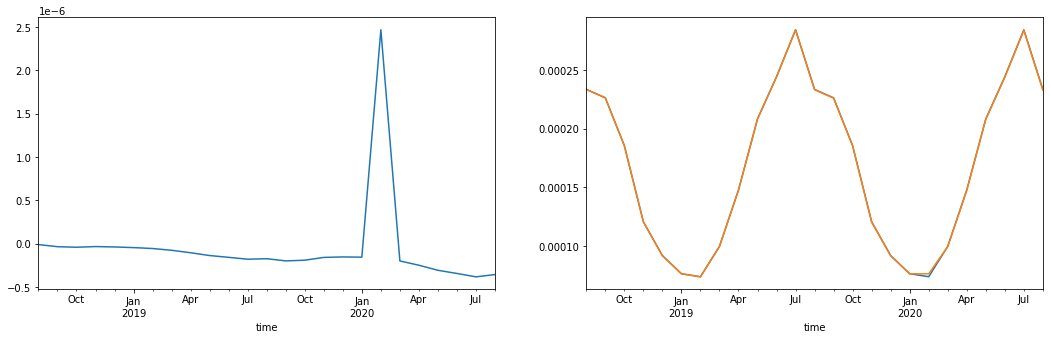

In [139]:
import pandas as pd

train_data, validation_data = utils.ts_train_test_split(nh3, .9)
validation_data = validation_data

best_model = ARIMA(train_data, order=min_aic_model['order'], seasonal_order=min_aic_model['seasonal_order']).fit()
predictions, errors = multiple_forecasts(model=best_model, ts=validation_data, times=len(validation_data), refit=False)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,5))

pd.Series(errors, index=validation_data.index).plot(ax=axs[0])

pd.Series(predictions, index=validation_data.index).plot(ax=axs[1])
validation_data.plot(ax=axs[1])
plt.show()

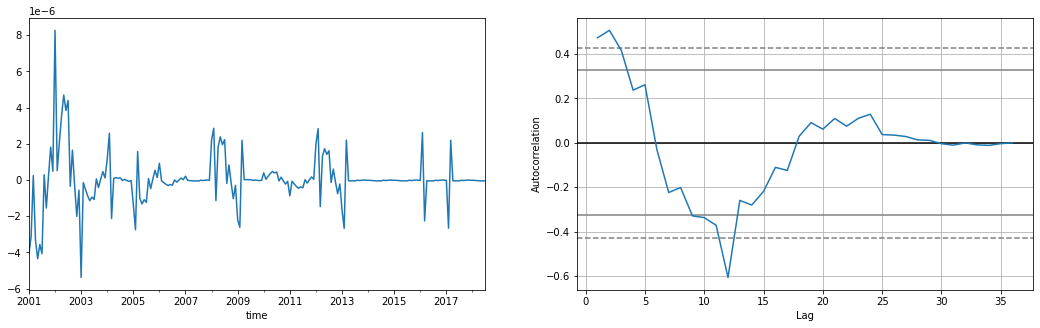

In [140]:
from pandas.plotting import autocorrelation_plot

errors = best_model.resid

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,5))

pd.Series(errors[12:]).plot(ax=axs[0])
autocorrelation_plot(errors[12:48], ax=axs[1])
plt.show()

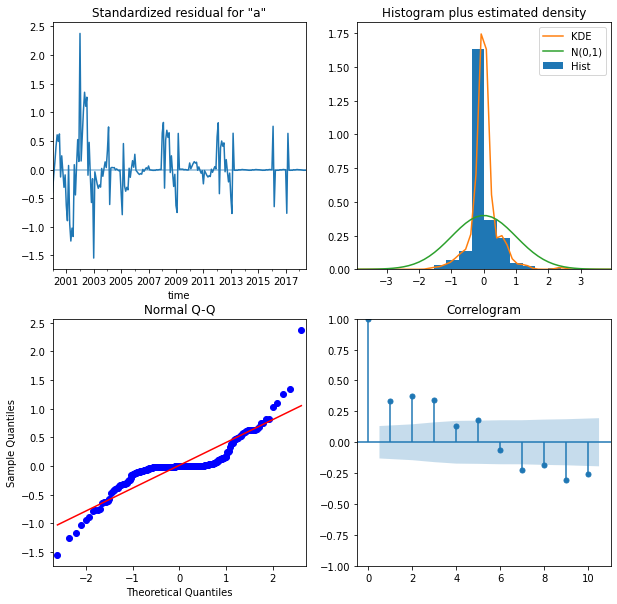

In [141]:
best_model.plot_diagnostics(figsize=(10,10))
plt.show()

Excluding the first 12 months due to seasonality

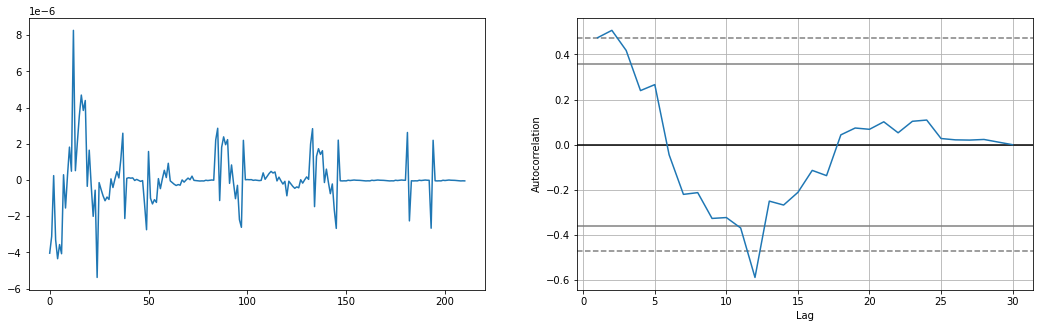

In [142]:
predictions = best_model.predict(start=train_data.index[12], end=train_data.index[-1])

errors = train_data[12:].values - predictions.values

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,5))

pd.Series(errors).plot(ax=axs[0])
autocorrelation_plot(errors[:30], ax=axs[1])
plt.show()

In [143]:
#  null hypothesis is of no heteroskedasticity

result = best_model.test_heteroskedasticity(method=None)
if result[0, 1] < 0.05: print('Eteroschedastici')
result

Eteroschedastici


array([[1.42074100e-01, 5.44111358e-15]])

In [144]:
best_model.test_normality('jarquebera')

array([[5.33609182e+002, 1.34350199e-116, 7.78850776e-001,
        1.04163574e+001]])

In [145]:
print(best_model.pvalues)

const       0.742570
ar.L1       0.000000
ar.S.L12    0.000000
sigma2      0.926577
dtype: float64


In [146]:
best_model.params

const       1.634134e-04
ar.L1       8.420229e-01
ar.S.L12    9.994619e-01
sigma2      1.210074e-11
dtype: float64

In [147]:
best_model.test_serial_correlation('boxpierce', lags=12)[0][1]

array([5.57234528e-07, 5.67268857e-13, 1.04518697e-17, 8.12344181e-18,
       1.10607361e-18, 3.50429888e-18, 5.74178276e-20, 7.26145868e-21,
       1.51252353e-24, 6.58084747e-27, 6.76547207e-30, 1.26535301e-44])

In [148]:
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(errors, model_df=len(best_model.param_names)-1)[1]

array([           nan,            nan,            nan, 9.24605577e-20,
       1.08284286e-20, 7.23651243e-20, 3.56555959e-21, 1.36966032e-21,
       2.17931087e-24, 4.87574943e-26, 4.93046719e-28, 5.84560096e-42,
       4.77578555e-43, 1.89962114e-43, 3.00819805e-44, 8.11689312e-44,
       1.52114553e-43, 6.26845971e-43, 5.84263060e-43, 1.47498425e-42,
       1.15157490e-42, 2.36289301e-42, 2.42940717e-42, 3.89546272e-43,
       1.04396860e-43, 3.67155696e-43, 5.43867189e-43, 1.74426258e-42,
       5.28843774e-42, 1.63429343e-41, 1.63833499e-41, 4.25965217e-41,
       4.82343742e-41, 1.00370669e-40, 2.38117157e-40, 3.87347057e-43,
       1.76342682e-43, 5.25780735e-43, 4.83785822e-43, 1.30311218e-42])

In [149]:
min_aic = np.min(aics)
candidate_models = [v for k,v in results.items() if v['aic'] < min_aic*0.95 ]

In [150]:
aics = [v['aic'] for v in candidate_models]
bics = [v['bic'] for v in candidate_models]
rmses = [v['rmse'] for v in candidate_models]
sses = [v['sse'] for v in candidate_models]
mses = [v['mse'] for v in candidate_models]
maacf = [v['mean_abs_acf'] for v in candidate_models]
yac_out_of_sample = [v['yac_out_of_sample'] for v in candidate_models]

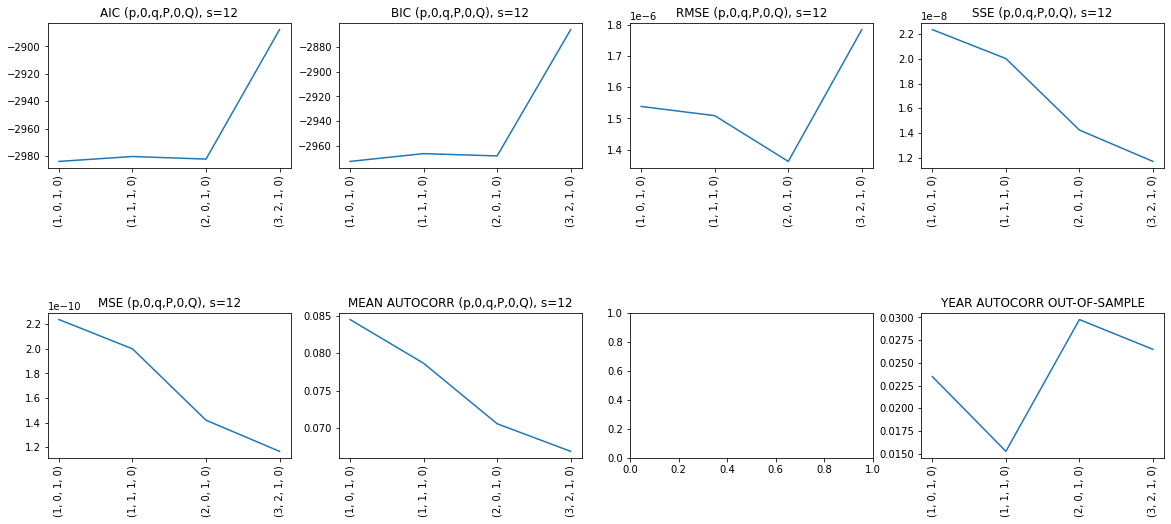

In [151]:
ticks = [tick(v['order'], v['seasonal_order']) for v in candidate_models]

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20,8))
indices = np.arange(0, len(candidate_models), 1)

fig.subplots_adjust(hspace=1)

axs[0,0].plot(aics)
axs[0,0].set_title('AIC (p,0,q,P,0,Q), s=12')
axs[0,0].set_xticks(indices)
axs[0,0].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[0,1].plot(bics)
axs[0,1].set_title('BIC (p,0,q,P,0,Q), s=12')
axs[0,1].set_xticks(indices)
axs[0,1].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[0,2].plot(rmses)
axs[0,2].set_title('RMSE (p,0,q,P,0,Q), s=12')
axs[0,2].set_xticks(indices)
axs[0,2].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[0,3].plot(sses)
axs[0,3].set_title('SSE (p,0,q,P,0,Q), s=12')
axs[0,3].set_xticks(indices)
axs[0,3].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[1,0].plot(mses)
axs[1,0].set_title('MSE (p,0,q,P,0,Q), s=12')
axs[1,0].set_xticks(indices)
axs[1,0].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[1,1].plot(maacf)
axs[1,1].set_title('MEAN AUTOCORR (p,0,q,P,0,Q), s=12')
axs[1,1].set_xticks(indices)
axs[1,1].set_xticklabels(np.array(ticks)[indices], rotation=90)

axs[1,3].plot(yac_out_of_sample)
axs[1,3].set_title('YEAR AUTOCORR OUT-OF-SAMPLE')
axs[1,3].set_xticks(indices)
axs[1,3].set_xticklabels(np.array(ticks)[indices], rotation=90)


plt.show()

In [152]:
best_model.test_normality(method='jarquebera')

array([[5.33609182e+002, 1.34350199e-116, 7.78850776e-001,
        1.04163574e+001]])